## Simple example reconstructing the sin function


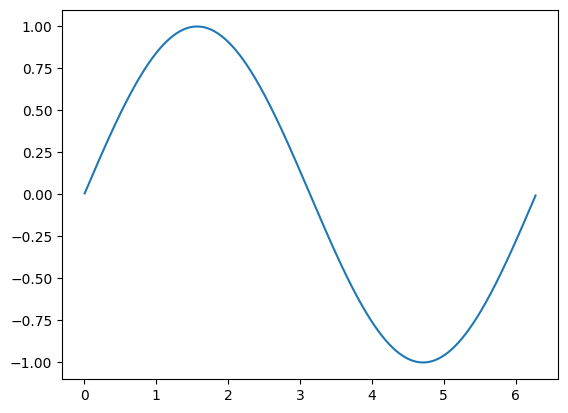

[0.006283185307179587, 0.012566370614359173, 0.01884955592153876, 0.025132741228718346, 0.031415926535897934, 0.03769911184307752, 0.04398229715025711, 0.05026548245743669, 0.05654866776461628, 0.06283185307179587, 0.06911503837897545, 0.07539822368615504, 0.08168140899333462, 0.08796459430051422, 0.0942477796076938, 0.10053096491487339, 0.10681415022205297, 0.11309733552923255, 0.11938052083641215, 0.12566370614359174, 0.13194689145077132, 0.1382300767579509, 0.1445132620651305, 0.15079644737231007, 0.15707963267948966, 0.16336281798666924, 0.16964600329384885, 0.17592918860102844, 0.18221237390820802, 0.1884955592153876, 0.1947787445225672, 0.20106192982974677, 0.20734511513692636, 0.21362830044410594, 0.21991148575128552, 0.2261946710584651, 0.2324778563656447, 0.2387610416728243, 0.2450442269800039, 0.25132741228718347, 0.25761059759436306, 0.26389378290154264, 0.2701769682087222, 0.2764601535159018, 0.2827433388230814, 0.289026524130261, 0.29530970943744056, 0.30159289474462014, 0

TypeError: estimator should be an estimator implementing 'fit' method, Net(
  (fc1): Linear(in_features=30, out_features=1, bias=True)
) was passed

In [2]:
import HPO

import math
import matplotlib.pyplot as plt

import torch.nn as nn

X = []
Y = []

for i in range(1, 1000):
    X.append(2.0*math.pi/1000.0 * float(i))
    Y.append(math.sin(2.0*math.pi/1000.0 * float(i)))

plt.plot(X, Y)
plt.show()

dataset = HPO.Dataset(X, Y)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(30, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

model = Net()

hyperparameterspace = {
    #'learning_rate': [0.0001],
    'epochs': [1, 300]
}


optimization = HPO.Optimization(dataset, model, hyperparameterspace, type=0)
result = optimization.fit()
print(result.best_params_)